In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import genjax
from dataclasses import dataclass
from genjax import dippl
from genjax import gensp
from genjax import select, dirac
import equinox as eqx
import jax
import jax.numpy as jnp
import adevjax
from datasets import *
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

console = genjax.pretty(show_locals=False)
key = jax.random.PRNGKey(314159)
train_images, train_labels, test_images, test_labels = mnist()

# Plotting.
sns.set_theme(style="white")

I0000 00:00:1696197534.470013   61463 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


## Visualize some of the data examples

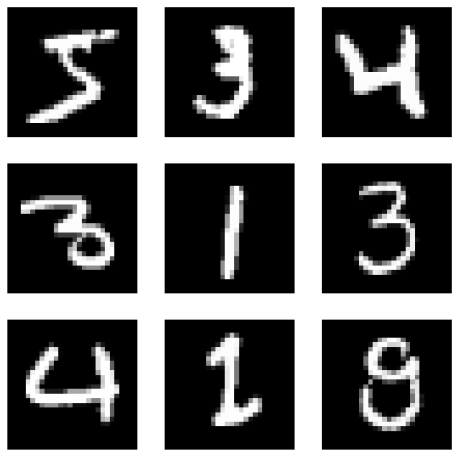

In [3]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
counter = 0
for (i, j) in itertools.product(range(0, 3), range(0, 3)):
    sub_axis = axs[i, j]
    sub_axis.set_axis_off()
    sub_axis.imshow(train_images[counter].reshape(28, 28) / 255.0, cmap="gray")
    counter += 10

## Gradients using `DIPPL`

In [4]:
@genjax.gen
def decoder_model(decoder):
    latent = dippl.mv_normal_reparam(jnp.zeros(10), jnp.eye(10)) @ "latent"
    image = decoder(latent)
    noisy_image = dippl.mv_normal_reparam(image, jnp.eye(784)) @ "image"


@genjax.gen
def encoder_model(encoder, chm):
    image = chm.get_leaf_value()["image"]
    μ, Σ = encoder(image)
    x = dippl.mv_normal_reparam(μ, Σ) @ "latent"


decoder_model = gensp.choice_map_distribution(
    decoder_model, select("latent", "image"), None
)
encoder_model = gensp.choice_map_distribution(encoder_model, select("latent"), None)

# Define our gradient estimator using our loss language.
def variational_grad(
    key,
    data,
    encoder,
    decoder,
):
    v_chm = genjax.value_choice_map(genjax.choice_map({"image": data}))

    @dippl.loss
    def vae_loss(encoder, decoder):
        v = dippl.upper(encoder_model)(encoder, v_chm)
        merged = gensp.merge(v, v_chm)
        dippl.lower(decoder_model)(merged, decoder)

    return vae_loss.grad_estimate(key, (encoder, decoder))


def minibatch_grad(key, data, encoder, decoder):
    sub_keys = jax.random.split(key, len(data))
    (encoder_grad, decoder_grad) = jax.vmap(
        variational_grad, in_axes=(0, 0, None, None)
    )(sub_keys, data, encoder, decoder)
    encoder_grad, decoder_grad = jtu.tree_map(
        lambda v: jnp.mean(v, axis=0), (encoder_grad, decoder_grad)
    )
    return encoder_grad, decoder_grad

## Encoder/decoder architectures

In [5]:
@dataclass
class EncoderNetwork(genjax.Pytree):
    layers: genjax.typing.List

    def flatten(self):
        return (self.layers,), ()

    def new(key, latent_dim):
        key, sub_key = jax.random.split(key)
        conv_1 = eqx.nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=3, stride=(2, 2), key=sub_key
        )
        key, sub_key = jax.random.split(key)
        conv_2 = eqx.nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=(2, 2), key=sub_key
        )
        dense = eqx.nn.Linear(
            in_features=2304, out_features=latent_dim + latent_dim, key=key
        )
        layers = [conv_1, conv_2, dense]
        return EncoderNetwork(layers)

    def __call__(self, v):
        v = v.reshape(1, 28, 28)
        for layer in self.layers[:-1]:
            v = jax.nn.relu(layer(v))
        v = v.flatten()
        v = self.layers[-1](v)  # Dense
        mu = v[0:10]
        sigma = v[10:]
        return mu, jnp.diag(sigma)


@dataclass
class DecoderNetwork(genjax.Pytree):
    layers: genjax.typing.List

    def flatten(self):
        return (self.layers,), ()

    def new(key, latent_dim):
        key, sub_key = jax.random.split(key)
        dense = eqx.nn.Linear(in_features=latent_dim, out_features=6 * 6 * 32, key=key)
        conv_tr_1 = eqx.nn.ConvTranspose2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=2, key=sub_key
        )
        key, sub_key = jax.random.split(key)
        conv_tr_2 = eqx.nn.ConvTranspose2d(
            in_channels=64, out_channels=32, kernel_size=3, stride=2, key=sub_key
        )
        key, sub_key = jax.random.split(key)
        conv_tr_3 = eqx.nn.ConvTranspose2d(
            in_channels=32, out_channels=1, kernel_size=2, stride=1, key=sub_key
        )
        layers = [dense, conv_tr_1, conv_tr_2, conv_tr_3]
        return DecoderNetwork(layers)

    def __call__(self, v):
        v = jax.nn.relu(self.layers[0](v))
        v = v.reshape(32, 6, 6)
        for layer in self.layers[1:]:
            v = jax.nn.relu(layer(v))
        v = v.reshape(784)
        return v

In [6]:
encoder_net = EncoderNetwork.new(key, 10)
mu, sigma = encoder_net(train_images[1])
(mu.shape, sigma.shape)

((10,), (10, 10))

In [7]:
decoder_net = DecoderNetwork.new(key, 10)
out = decoder_net(jnp.ones(10))
out.shape

(784,)

## Training

In [8]:
jax.jit(variational_grad)(key, train_images[1], encoder_net, decoder_net)


(
    EncoderNetwork(
        layers=[
            Conv2d(
  num_spatial_dims=2,
  weight=f32[32,1,3,3],
  bias=f32[32,1,1],
  in_channels=1,
  out_channels=32,
  kernel_size=(3, 3),
  stride=(2, 2),
  padding=((0, 0), (0, 0)),
  dilation=(1, 1),
  groups=1,
  use_bias=True
),
            Conv2d(
  num_spatial_dims=2,
  weight=f32[64,32,3,3],
  bias=f32[64,1,1],
  in_channels=32,
  out_channels=64,
  kernel_size=(3, 3),
  stride=(2, 2),
  padding=((0, 0), (0, 0)),
  dilation=(1, 1),
  groups=1,
  use_bias=True
),
            Linear(
  weight=f32[20,2304],
  bias=f32[20],
  in_features=2304,
  out_features=20,
  use_bias=True
)
        ]
    ),
    DecoderNetwork(
        layers=[
            Linear(
  weight=f32[1152,10],
  bias=f32[1152],
  in_features=10,
  out_features=1152,
  use_bias=True
),
            ConvTranspose2d(
  num_spatial_dims=2,
  weight=f32[64,32,3,3],
  bias=f32[64,1,1],
  in_channels=32,
  out_channels=64,
  kernel_size=(3, 3),
  stride=(2, 2),
  padding=((0, 0), 